In [1]:
#Import Model, images, and fonts directories from GDRIVE
from google.colab import drive, files
import os
for dirname in ["final_model", "images", "fonts", "data/image_label_map.pbtxt"]:
  path = os.path.join("/content/drive/My\ Drive/ML/Twitter_Model_Data/", dirname)
  dest = "/content"
  !cp -avr $path $dest

#import one extra file (pbtxt)

'/content/drive/My Drive/ML/Twitter_Model_Data/final_model' -> '/content/final_model'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/model.ckpt.data-00000-of-00001' -> '/content/final_model/model.ckpt.data-00000-of-00001'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/checkpoint' -> '/content/final_model/checkpoint'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/model.ckpt.index' -> '/content/final_model/model.ckpt.index'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/model.ckpt.meta' -> '/content/final_model/model.ckpt.meta'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/frozen_inference_graph.pb' -> '/content/final_model/frozen_inference_graph.pb'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/saved_model' -> '/content/final_model/saved_model'
'/content/drive/My Drive/ML/Twitter_Model_Data/final_model/saved_model/variables' -> '/content/final_model/saved_model/variables'
'/content/drive/My Drive/ML/Twitter_Model_

In [38]:
#Imports and function definitions

import tensorflow as tf
# For running inference on the TF-Hub module.
import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import zipfile
import tarfile

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.2.0-rc3
The following GPU devices are available: 


In [0]:
#Draw Bounding Boxes
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a Bounding Box To an Image"""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
            width = thickness,
            fill = color
            )
  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, classes, class_map, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  #Class Map -> map that converts class ids to class name
  #colors -> Just a list of colors to make the boxes pretty 
  colors = list(ImageColor.colormap.values())
  try:
    font = ImageFont.truetype("/content/fonts/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  #Only get Boxes with score above min_score
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_map[classes[i]],
                                     int(100 * scores[i]))
      color = colors[int(classes[i]) % len(colors)]
      image_pil = Image.fromarray(image)
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [0]:
#utility functions
def load_model(path):
  #expects a path to saved_model directory
  model = tf.saved_model.load(path)
  return model

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

def load_img(image_path):
  img = Image.open(image_path)
  #image for png has 4 channels, convert to 3
  img = img.convert("RGB")
  img = np.array(img)
  return img

def get_preds_for_single_image(model, image_path):
  label_map = get_class_map("/content/image_label_map.pbtxt")
  img = load_img(image_path)
  img = tf.convert_to_tensor(img)
  #model optimized on batches, give batch of images (image) to model
  img = img[tf.newaxis, ...]
  output_dict = model(img)
  #prediction containing boxes, classes, etc.
  print(output_dict["detection_boxes"].shape)
  #output is a batch (since we only have 1 image) get first element of batch
  result = {key:value[0].numpy() for key,value in output_dict.items()}
  #since the img (tensor type) has a batch dimension, remove it to get original np array
  image_with_boxes = draw_boxes(
      img.numpy()[0], result["detection_boxes"],
      result["detection_classes"], label_map, result["detection_scores"])
  display_image(image_with_boxes)
  return result

def get_boxes(result, max_boxes = 10, min_score=0.1):
  if(max_boxes == -1):
    max_boxes = np.inf
  boxes = result["detection_boxes"]
  scores = result["detection_scores"]

  all_boxes = []

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] > min_score:
      xmin, ymin, xmax, ymax = tuple(boxes[i])
      all_boxes.append(tuple(boxes[i]))
    
  print(i)
  return np.array(all_boxes)

def get_mapping(iterable, label_map):
  #initialize class_id, and class_name values
  class_id = None
  class_name = None
  #strip to remove whitespace
  next_ele = next(iterable).strip()
  #check if end of dict element has been reached
  while(not "}" in next_ele):
    #partition each string and get the component after keyword (ID, NAME)
    if("id" in next_ele):
      partition = next_ele.partition("id: ")
      class_id = int(partition[-1])
    else:
      partition = next_ele.partition("name: ")
      class_name = partition[-1].replace('"', '')
    next_ele = next(iterable).strip()

  #add new class mapping
  label_map[class_id] = class_name
  return label_map

def get_class_map(label_map_path):
  with tf.io.gfile.GFile(label_map_path, 'r') as fid:
    list_mappings = fid.readlines()
  items = list_mappings.count("item {\n")
  #iterable so we don't have to use enumerate and indices
  iterable = iter(list_mappings)
  #initialize label_map
  label_map = {}

  #iterate through all class elements
  while items > 0:
    element = next(iterable)
    #check if new class element has been reached
    if("item" in element):
      label_map = get_mapping(iterable, label_map)
      items -= 1

  return label_map

In [34]:
img_path = None
for dirpath, dirnames, dirfiles in os.walk("/content/images/test_images"):
  for dirfile in dirfiles:
    img_path = os.path.join(dirpath, dirfile)
print(img_path)

model_path = "/content/final_model/saved_model"
model = load_model(model_path)
model = model.signatures['serving_default']

/content/images/test_images/Screen Shot 2019-10-24 at 7.00.36 PM.png
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(1, 100, 4)


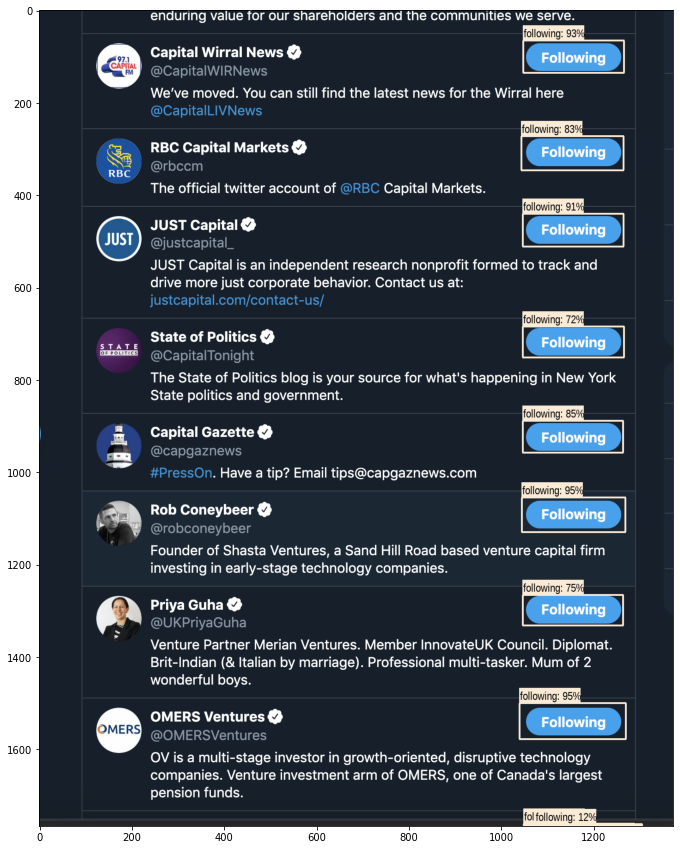

In [35]:
result = get_preds_for_single_image(model, img_path)

In [36]:
output = get_boxes(result, max_boxes=-1)
print(output)

99
[[0.84949404 0.75787985 0.89321    0.92631817]
 [0.59780425 0.76108193 0.63935786 0.9254141 ]
 [0.03760987 0.7634006  0.07650543 0.9231115 ]
 [0.2501275  0.7625073  0.28971922 0.9224855 ]
 [0.5036584  0.76255673 0.54220915 0.9218479 ]
 [0.15463513 0.76029223 0.19593433 0.92264456]
 [0.71705616 0.7629209  0.7542238  0.921598  ]
 [0.3883453  0.7629788  0.42542672 0.9228436 ]
 [0.99741083 0.7644868  0.9992624  0.93897235]
 [0.9978763  0.7821411  0.99949956 0.9512192 ]]


{1: 'following'}


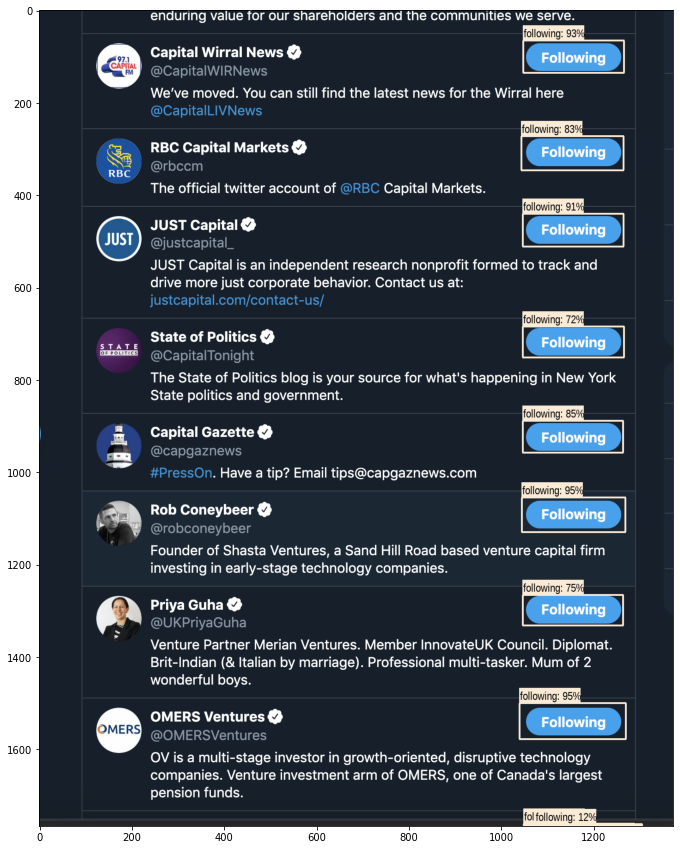

In [37]:
label_map = get_class_map("/content/image_label_map.pbtxt")
print(label_map)

image_with_boxes = draw_boxes(load_img(img_path), result["detection_boxes"], result["detection_classes"], label_map, result["detection_scores"])
display_image(image_with_boxes)